Filename:     main.py 

Description:  main function for the poisson solver project

Author:       Nithin Adiddela

Created:      2025 April 02

Modified:     2025 April 02

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import latex newcommands
$$
\renewcommand{\grad}[1]{\nabla{#1}}
\renewcommand{\lapl}[1]{\nabla^2{#1}}
\renewcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\pdd}[2]{\frac{\partial^2#1}{\partial#2^2}}
$$

Poisson's equation in variable u with sources f is written as
$$
\lapl(u) = f
$$
It is posed as a boundary value problem (BVP) in 2D with the ODE
$$
\pdd{u}{x} + \pdd{u}{x} = f \,\, \forall \,\, 0 < x, y < L ,
$$
where L is the length of the domain, and with the boundary conditions (BCs)
$$
u = g  \,\, \forall \,\, x = y = 0 \,\, \& \,\, x, y = L,
$$
We discretize the ODE using 2^d order central difference for 2^d derivative using
$$
\Delta x = \Delta y = L / (N + 1),
$$
where N is the number of internal points to get
$$
(u_{i+1, j} + u_{i-1, j} - 2 u_{i, j}) + (u_{i, j+1} + u_{i, j-1} - 2 u_{i, j}) = f_{i, j} \frac{1}{4} \Delta x^2.
$$
Let us develop numerical methods to solve this equation with the following benchmark problem: 
$$
u = sin(\frac{4 \pi x}{L}) cos(\frac{4 \pi x}{L}), 
$$
which implies that $f \equiv \lapl{u} = $
$$
f = - 16 \frac{\pi^2}{L^2} (sin(\frac{4 \pi x}{L}) cos(\frac{4 \pi x}{L}))
$$

In [22]:
'''Length of the domain'''
L = 1.0
''' No. of interior grid points in each dimension '''
N = 2**8
''' No. of exterion (ghost) points in each dimension '''
Ng = 2
''' No. of total grid points in each dimension ''' 
NpG = N + Ng 
''' Grid spacing '''
dx = (L - 0) / (N + 1)
''' Grid lines '''
x = np.linspace(0, L, NpG)
y = np.linspace(0, L, NpG)
''' Meshgrid '''
X, Y = np.meshgrid(x, y)
''' Benchmark solution '''
freq = 2.
u_ref = np.sin(freq * np.pi * X / L) * np.cos(freq * np.pi * Y / L)
''' source term '''
f = -freq**2. * np.pi**2 * np.sin(freq * np.pi * X / L) * np.cos(freq * np.pi * Y / L)
''' solution array '''
u = np.zeros((NpG, NpG))
''' Set the boundary condition '''
'''Bottom'''
u[0, :] = 0.
'''Top'''
u[-1, :] = 0.
'''Left'''
u[:, 0] = 0.
'''Right'''
u[:, -1] = 0.

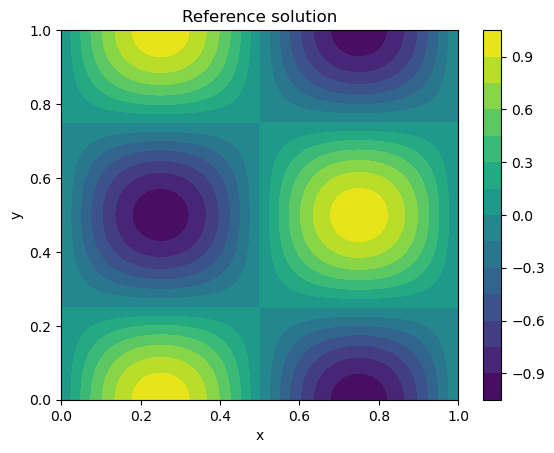

In [23]:
plt.figure()
plt.contourf(X, Y, u_ref, levels=16, cmap='viridis')
plt.colorbar()
plt.title('Reference solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Point Gauss-Jacobi / Point Gauss-Seidel Method

We rearrange the earlier equation in terms of $u_{i, j}$ as
$$
u^{n+1}_{i, j} = \frac{1}{4} (u^n_{i+1, j} + u^n_{i-1, j} + u^n_{i, j+1} + u^n_{i, j+1}) + f_{i, j} \Delta x^2
$$